<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_NLP_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TensorFlow Natural Language Processing

In [1]:
import tensorflow as tf

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random

from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Embedding, TextVectorization
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, GlobalMaxPool1D, Input
from tensorflow.keras.layers import Bidirectional, Conv1D, GRU, LSTM

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

## Setup

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100
plt.style.use('seaborn-darkgrid')

## Constantes

In [47]:
SEMENTE = 2008193

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'sigmoid'

FILTROS = 32
NUCLEO_TAMANHO = 32
PREENCHIMENTO = 'same'

PERDA = 'binary_crossentropy'
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 5

DIRETORIO_TB = 'tb_nlp'

## Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-01-28 21:44:57--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5196 (5.1K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   5.07K  --.-KB/s    in 0s      

2023-01-28 21:44:57 (63.1 MB/s) - ‘funcoes.py’ saved [5196/5196]



In [5]:
from funcoes import criar_callback_tensorboard, grafico_historico_por_iteracao, unzip_data

In [6]:
def avaliar_modelo(previsao, validacao):
    print(classification_report(validacao, previsao))

    ConfusionMatrixDisplay.from_predictions(validacao, previsao, cmap='summer_r')
    plt.grid(False)

    relatorio = classification_report(validacao, previsao, output_dict=True)

    return {'acuracia': relatorio['accuracy'],
            'precisao': relatorio['weighted avg']['precision'],
            'revocacao': relatorio['weighted avg']['recall'],
            'pontuacao-f1': relatorio['weighted avg']['f1-score']}

## Dados

Dados originalmente da competição **Natural Language Processing with Disaster Tweets** no Kaggle. (Em andamento em 27.01.2023.)

https://www.kaggle.com/c/nlp-getting-started

In [7]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

unzip_data('nlp_getting_started.zip')

--2023-01-28 21:44:58--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.152.128, 142.250.128.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.152.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2023-01-28 21:44:58 (56.1 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [8]:
df_treino = pd.read_csv('train.csv')
df_teste = pd.read_csv('test.csv')

# Embaralhar dados de treino (frac=1 = 100% dos dados)
df_treino = df_treino.sample(frac=1, random_state=SEMENTE)

In [9]:
df_treino.head()

,id,keyword,location,text,target
2299,3299,demolish,NYHC,If you think going to demolish Drake's house o...,1
3704,5269,fear,Carregado,I didn`t want to hurt you but the fear drove m...,0
3468,4961,explosion,New York,New Explosion-proof Tempered Glass Screen Prot...,0
6653,9533,terrorist,????? ???? ????,#UdhampurAgain 2 terrorist shot dead.. #Udhampur,1
3634,5183,fatalities,jersey,mortal kombat fatalities are so gross but inte...,0


In [10]:
df_treino.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7613 entries, 2299 to 4895
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 356.9+ KB


In [11]:
df_treino['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

### Separar dados para validação

In [12]:
X = df_treino['text']
y = df_treino['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

## Converter texto em números

### Vetorização (Vectorization)

In [13]:
limite_dicionario = 10000
media_palavras_por_texto = round(sum([len(texto.split()) for texto in X_train]) / len(X_train))

vetorizador = TextVectorization(max_tokens=limite_dicionario,                     # (Default: None) Máximo de tokens (palavras) no dicionário.
                                standardize='lower_and_strip_punctuation',        # (Default) Texto em caixa baixa e retira caracteres especiais.
                                split='whitespace',                               # (Default) Separador de tokens.
                                ngrams=None,                                      # (Default) Tokens por grupo. (None = não agrupar tokens.)
                                output_mode='int',                                # (Default) Como mapear tokens para números.
                                output_sequence_length=media_palavras_por_texto)  # (Default: None) Tamanho do texto, completado ou truncado, se necessário. (Válido apenas para 'int'.)

In [14]:
vetorizador.adapt(X_train)

In [15]:
texto = random.choice(X_train)
print(texto)

vetorizador([texto])

Horrific attack on wife by muslim in Italy http://t.co/nY3l1oRZQb LiveLeak #News


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[3799,  113,   11, 1169,   18, 2853,    4, 2084,    1,    1,   63,
           0,    0,    0,    0]])>

In [16]:
vocabulario = vetorizador.get_vocabulary()

In [17]:
# [UNK] = Desconhecido, fora do limite do dicionário.
len(vocabulario), vocabulario[:5], vocabulario[-5:]

(10000,
 ['', '[UNK]', 'the', 'a', 'in'],
 ['pacic', 'p45perez', 'oyster', 'oworoshoki', 'ownership'])

### Incorporação (Embedding)

In [18]:
incorporador = Embedding(input_dim=limite_dicionario,            # Tamanho do vocabulário de entrada.
                         output_dim=128,                         # Dimensão do vetor de saída. (Geralmente um múltiplo de 8.)
                         input_length=media_palavras_por_texto)  # Tamanho do texto de entrada.

In [19]:
texto = random.choice(X_train)
print(texto)

incorporador(vetorizador([texto]))

RT NotExplained: The only known image of infamous hijacker D.B. Cooper. http://t.co/JlzK2HdeTG


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01370956,  0.0460613 , -0.00885776, ..., -0.01225585,
          0.03284982, -0.03858514],
        [ 0.02216739,  0.04933823, -0.00017145, ...,  0.04048959,
          0.04780437,  0.02452208],
        [-0.02495234, -0.0396213 , -0.04813653, ...,  0.03948741,
         -0.01019971,  0.02033284],
        ...,
        [ 0.0452865 ,  0.02811164,  0.03251687, ..., -0.01351436,
         -0.0206346 ,  0.01456802],
        [ 0.0452865 ,  0.02811164,  0.03251687, ..., -0.01351436,
         -0.0206346 ,  0.01456802],
        [ 0.0452865 ,  0.02811164,  0.03251687, ..., -0.01351436,
         -0.0206346 ,  0.01456802]]], dtype=float32)>

## Experimentos

* Model 0: Naive Bayes with TF-IDF encoder (baseline)
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional LSTM (RNN)
* Model 5: 1D Convolutional Neural Network
* Model 6: TFHub Pretrained Word Embedding (feature extractor)
* Model 7: Same as model 6 but using 10% of data

In [20]:
modelos = [None] * 8
avaliacoes = [None] * 8
previsoes = [None] * 8
relatorios = [None] * 8
historicos = [None] * 8

### Modelo 0: Naive Bayes with TF-IDF encoder (baseline)

In [21]:
modelos[0] = Pipeline([('tdidf', TfidfVectorizer()),
                       ('clf', MultinomialNB())]) # clf = classifier

modelos[0].fit(X_train, y_train)

Pipeline(steps=[('tdidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [22]:
avaliacoes[0] = modelos[0].score(X_test, y_test)
avaliacoes[0]

0.8083989501312336

In [23]:
previsoes[0] = modelos[0].predict(X_test)
previsoes[0][:20]

array([0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1])

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       433
           1       0.88      0.64      0.74       329

    accuracy                           0.81       762
   macro avg       0.83      0.79      0.80       762
weighted avg       0.82      0.81      0.80       762



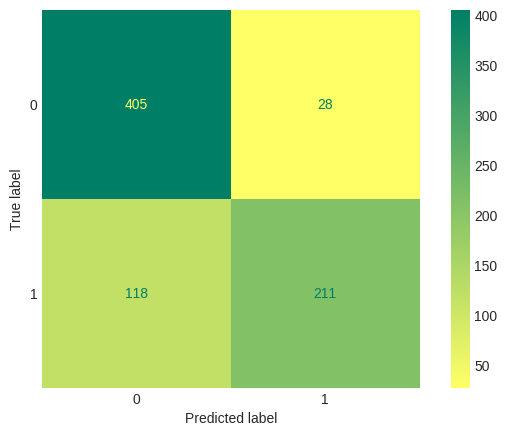

In [24]:
relatorios[0] = avaliar_modelo(previsoes[0], y_test)

In [25]:
relatorios[0]

{'acuracia': 0.8083989501312336,
 'precisao': 0.821209966257038,
 'revocacao': 0.8083989501312336,
 'pontuacao-f1': 0.8022381673606139}

### Modelo 1: Feed-forward neural network (dense model)

In [26]:
modelo_nome = 'modelo_1_dense'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)
camadas = GlobalAveragePooling1D(name='agrupamento_media_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[1] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[1].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[1] = modelos[1].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_1_dense/20230128-214504'.
Epoch 1/5
215/215 [==============================] - 16s 63ms/step - loss: 0.6118 - accuracy: 0.6961 - val_loss: 0.5165 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 7s 30ms/step - loss: 0.4446 - accuracy: 0.8194 - val_loss: 0.4389 - val_accuracy: 0.8084
Epoch 3/5
215/215 [==============================] - 5s 22ms/step - loss: 0.3496 - accuracy: 0.8621 - val_loss: 0.4205 - val_accuracy: 0.8150
Epoch 4/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2873 - accuracy: 0.8875 - val_loss: 0.4189 - val_accuracy: 0.8123
Epoch 5/5
215/215 [==============================] - 5s 22ms/step - loss: 0.2397 - accuracy: 0.9092 - val_loss: 0.4311 - val_accuracy: 0.7979


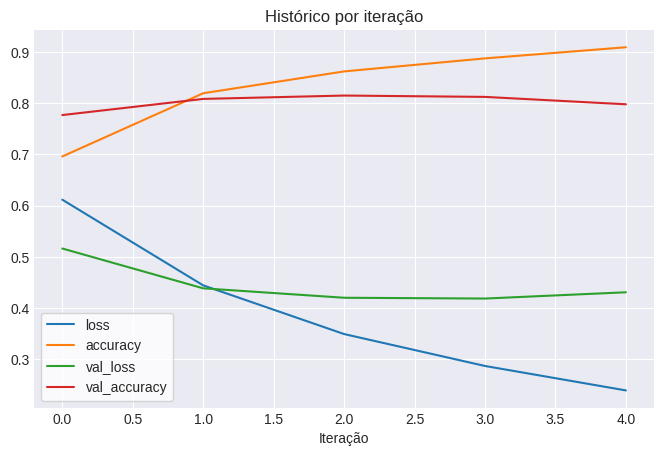

In [27]:
grafico_historico_por_iteracao(historicos[1])

24/24 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.82      0.83      0.82       433
           1       0.77      0.76      0.76       329

    accuracy                           0.80       762
   macro avg       0.79      0.79      0.79       762
weighted avg       0.80      0.80      0.80       762



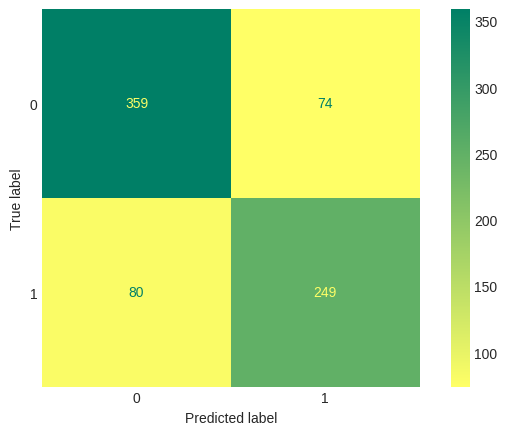

In [28]:
avaliacoes[1] = modelos[1].evaluate(X_test, y_test)
previsoes[1] = tf.squeeze(tf.round(modelos[1].predict(X_test)))
relatorios[1] = avaliar_modelo(previsoes[1], y_test)

In [29]:
relatorios[1]

{'acuracia': 0.7979002624671916,
 'precisao': 0.7975312087589932,
 'revocacao': 0.7979002624671916,
 'pontuacao-f1': 0.7976656529615568}

### Modelo 2: LSTM model (RNN)

In [30]:
modelo_nome = 'modelo_2_lstm'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = LSTM(units=64, activation=ATIVACAO_RNN, return_sequences=True)(camadas) # Para empilhar camadas recorrentes é necessário return_sequences=True
camadas = LSTM(units=64, activation=ATIVACAO_RNN)(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[2] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[2].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[2] = modelos[2].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_2_lstm/20230128-214547'.
Epoch 1/5
215/215 [==============================] - 17s 59ms/step - loss: 0.2252 - accuracy: 0.9228 - val_loss: 0.5074 - val_accuracy: 0.7953
Epoch 2/5
215/215 [==============================] - 11s 50ms/step - loss: 0.1567 - accuracy: 0.9435 - val_loss: 0.5525 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 11s 50ms/step - loss: 0.1285 - accuracy: 0.9540 - val_loss: 0.6452 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 10s 48ms/step - loss: 0.1079 - accuracy: 0.9612 - val_loss: 0.6462 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 8s 35ms/step - loss: 0.0922 - accuracy: 0.9667 - val_loss: 0.7514 - val_accuracy: 0.7690


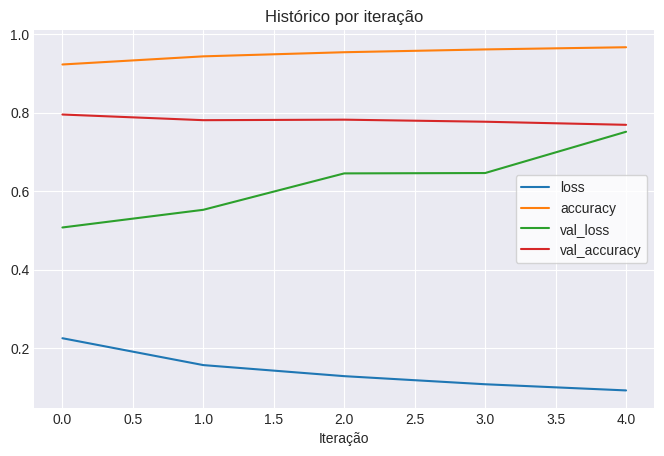

In [31]:
grafico_historico_por_iteracao(historicos[2])

24/24 [==============================] - 1s 6ms/step
              precision    recall  f1-score   support

           0       0.79      0.82      0.80       433
           1       0.74      0.71      0.73       329

    accuracy                           0.77       762
   macro avg       0.77      0.76      0.76       762
weighted avg       0.77      0.77      0.77       762



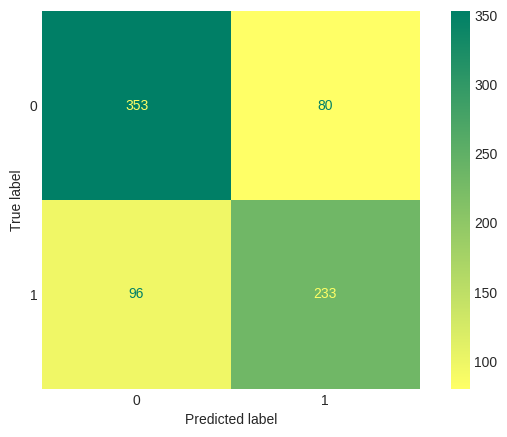

In [32]:
avaliacoes[2] = modelos[2].evaluate(X_test, y_test)
previsoes[2] = tf.squeeze(tf.round(modelos[2].predict(X_test)))
relatorios[2] = avaliar_modelo(previsoes[2], y_test)

In [33]:
relatorios[2]

{'acuracia': 0.7690288713910761,
 'precisao': 0.7681515466443795,
 'revocacao': 0.7690288713910761,
 'pontuacao-f1': 0.7682457027095021}

### Modelo 3: GRU model (RNN)

In [34]:
modelo_nome = 'modelo_3_gru'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = GRU(units=64, activation=ATIVACAO_RNN, return_sequences=True)(camadas)
camadas = GRU(units=64, activation=ATIVACAO_RNN)(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camda_saida')(camadas)

modelos[3] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[3].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[3] = modelos[3].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_3_gru/20230128-214714'.
Epoch 1/5
215/215 [==============================] - 8s 29ms/step - loss: 0.1578 - accuracy: 0.9415 - val_loss: 0.6664 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.0862 - accuracy: 0.9692 - val_loss: 0.7382 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0763 - accuracy: 0.9729 - val_loss: 0.7758 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 11s 52ms/step - loss: 0.0665 - accuracy: 0.9758 - val_loss: 0.9017 - val_accuracy: 0.7664
Epoch 5/5
215/215 [==============================] - 10s 44ms/step - loss: 0.0639 - accuracy: 0.9762 - val_loss: 0.8839 - val_accuracy: 0.7638


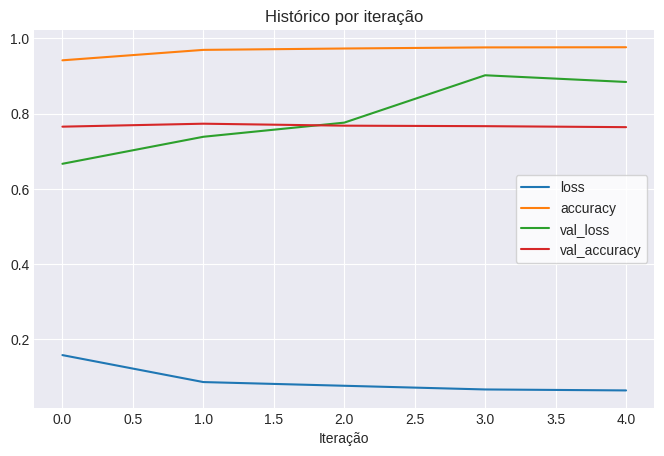

In [35]:
grafico_historico_por_iteracao(historicos[3])

24/24 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       433
           1       0.73      0.73      0.73       329

    accuracy                           0.76       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.76      0.76      0.76       762



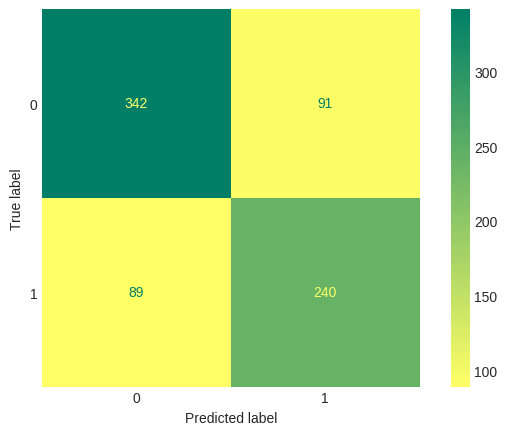

In [36]:
avaliacoes[3] = modelos[3].evaluate(X_test, y_test)
previsoes[3] = tf.squeeze(tf.round(modelos[3].predict(X_test)))
relatorios[3] = avaliar_modelo(previsoes[3], y_test)

In [37]:
relatorios[3]

{'acuracia': 0.7637795275590551,
 'precisao': 0.7639591284818308,
 'revocacao': 0.7637795275590551,
 'pontuacao-f1': 0.7638640340411995}

### Modelo 4: Bidirectional LSTM (RNN)

In [38]:
modelo_nome = 'modelo_4_bidirectional_lstm'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

# camadas = Bidirectional(layer=LSTM(units=64, activation=ATIVACAO_RNN, return_sequences=True))(camadas)
camadas = Bidirectional(layer=LSTM(units=64, activation=ATIVACAO_RNN))(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[4] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[4].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[4] = modelos[4].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_4_bidirectional_lstm/20230128-214804'.
Epoch 1/5
215/215 [==============================] - 17s 41ms/step - loss: 0.1064 - accuracy: 0.9704 - val_loss: 0.7978 - val_accuracy: 0.7703
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.0587 - accuracy: 0.9768 - val_loss: 0.8776 - val_accuracy: 0.7651
Epoch 3/5
215/215 [==============================] - 8s 36ms/step - loss: 0.0533 - accuracy: 0.9759 - val_loss: 1.1116 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 13s 59ms/step - loss: 0.0462 - accuracy: 0.9771 - val_loss: 1.1420 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 9s 43ms/step - loss: 0.0420 - accuracy: 0.9801 - val_loss: 1.2647 - val_accuracy: 0.7638


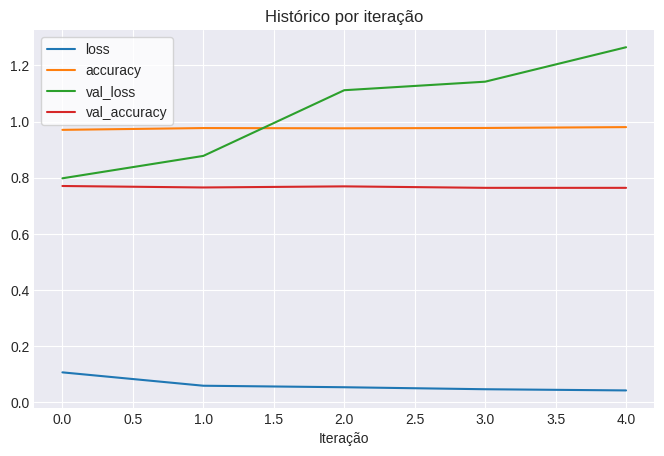

In [39]:
grafico_historico_por_iteracao(historicos[4])

24/24 [==============================] - 1s 7ms/step
              precision    recall  f1-score   support

           0       0.78      0.82      0.80       433
           1       0.74      0.69      0.72       329

    accuracy                           0.76       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.76      0.76      0.76       762



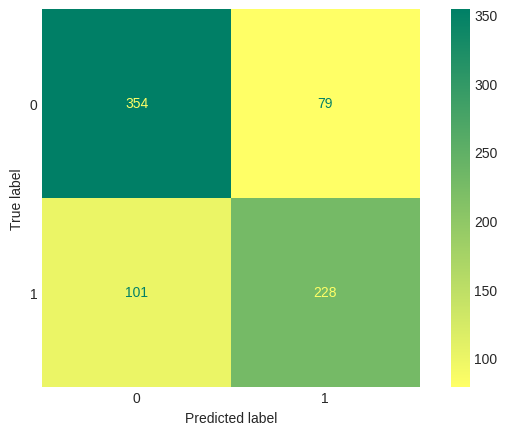

In [40]:
avaliacoes[4] = modelos[4].evaluate(X_test, y_test)
previsoes[4] = tf.squeeze(tf.round(modelos[4].predict(X_test)))
relatorios[4] = avaliar_modelo(previsoes[4], y_test)

In [41]:
relatorios[4]

{'acuracia': 0.7637795275590551,
 'precisao': 0.7627588959297903,
 'revocacao': 0.7637795275590551,
 'pontuacao-f1': 0.7626201078511285}

### Modelo 5: 1D Convolutional Neural Network

In [51]:
modelo_nome = 'modelo_5_1d_cnn'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada')

camadas = vetorizador(entradas)
camadas = incorporador(camadas)

camadas = Conv1D(filters=FILTROS,
                 kernel_size=NUCLEO_TAMANHO,  # Quantidade de palavras processadas por vez.
                 activation=ATIVACAO_CNN,
                 padding=PREENCHIMENTO,
                 name='camada_convulacional')(camadas)

camadas = GlobalMaxPool1D(name='agrupamento_maximo_global')(camadas)

saidas = Dense(1, activation=ATIVACAO_SAIDA, name='camada_saida')(camadas)

modelos[5] = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

modelos[5].compile(loss=PERDA,
                   optimizer=Adam(learning_rate=APRENDIZADO),
                   metrics=METRICAS)

historicos[5] = modelos[5].fit(x=X_train,
                               y=y_train,
                               epochs=ITERACOES,
                               validation_data=(X_test, y_test),
                               callbacks=[criar_callback_tensorboard(diretorio=DIRETORIO_TB, experimento=modelo_nome)],
                               verbose=1)

Salvando log TensorBoard em: 'tb_nlp/modelo_5_1d_cnn/20230128-221521'.
Epoch 1/5
215/215 [==============================] - 10s 43ms/step - loss: 0.0876 - accuracy: 0.9755 - val_loss: 0.9741 - val_accuracy: 0.7559
Epoch 2/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0589 - accuracy: 0.9780 - val_loss: 1.0515 - val_accuracy: 0.7703
Epoch 3/5
215/215 [==============================] - 12s 58ms/step - loss: 0.0532 - accuracy: 0.9790 - val_loss: 1.0871 - val_accuracy: 0.7664
Epoch 4/5
215/215 [==============================] - 14s 64ms/step - loss: 0.0507 - accuracy: 0.9778 - val_loss: 1.2055 - val_accuracy: 0.7559
Epoch 5/5
215/215 [==============================] - 13s 61ms/step - loss: 0.0452 - accuracy: 0.9787 - val_loss: 1.1954 - val_accuracy: 0.7625


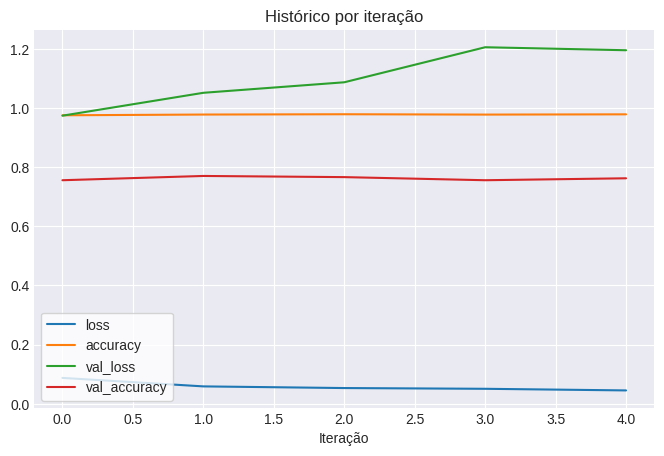

In [52]:
grafico_historico_por_iteracao(historicos[5])

24/24 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.79      0.79      0.79       433
           1       0.72      0.73      0.73       329

    accuracy                           0.76       762
   macro avg       0.76      0.76      0.76       762
weighted avg       0.76      0.76      0.76       762



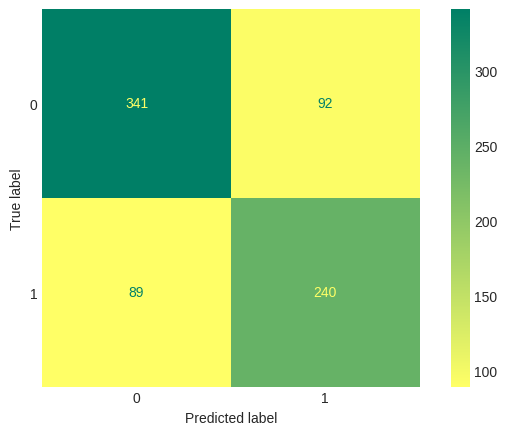

In [53]:
avaliacoes[5] = modelos[5].evaluate(X_test, y_test)
previsoes[5] = tf.squeeze(tf.round(modelos[5].predict(X_test)))
relatorios[5] = avaliar_modelo(previsoes[5], y_test)

In [54]:
relatorios[5]

{'acuracia': 0.7624671916010499,
 'precisao': 0.7627433006150219,
 'revocacao': 0.7624671916010499,
 'pontuacao-f1': 0.7625933609833455}